# NYC Capital Projects

## Notebook 10: Generate Ensemble Tree Models Using AdaBoost 

This notebook explores the use of ensemble decision tree models to predict `Budget_Change_Ratio` and `Schedule_Change_Ratio` as a (1) non-parametric alternative to the linear and smoothing spline models employed in prior notebooks, and (2) an improvement over the simple single-tree models employed in the previous notebook. Here we find a significant improvement in model performance while using the AdaBoost ensemble algorithm. Once again, we combinatorically explore our possible feature-space to identify the best combination of features to use in our models.

### Project authors

- [An Hoang](https://github.com/hoangthienan95)
- [Mark McDonald](https://github.com/mcdomx)
- [Mike Sedelmeyer](https://github.com/sedelmeyer)

### Inputs:

The following files are required to successfully run this notebook.

- ``../data/processed/NYC_capital_projects_3yr_final_train.csv``

    The final training dataset, including all engineered features, for use in prediction models.


- ``../data/processed/NYC_capital_projects_3yr_final_test.csv``

    The final test dataset, including all engineered features, for use in prediction models.

### Outputs:

No files are generated during execution of this notebook.


# Notebook contents

1. [Import libraries and load data](#Import-libraries-and-load-data)

2. [Define staged score functions](#Define-staged-score-functions)

3. [Fit boosted tree models using sklearn AdaBoostRegressor](#Fit-boosted-tree-models-using-sklearn-AdaBoostRegressor)

4. [Review impact of n estimators and max depth on model performance](#Review-impact-of-n-estimators-and-max-depth-on-model-performance)

5. [Best scoring model to predict "Budget Change Ratio"](#Best-scoring-model-to-predict-"Budget-Change-Ratio")

6. [Best scoring model to predict "Schedule Change Ratio"](#Best-scoring-model-to-predict-"Schedule-Change-Ratio")

# Import libraries and load data

[Return to top](#Notebook-contents)

In [1]:
import itertools
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm.notebook import tqdm

from caproj.model import generate_model_dict
from caproj.visualize import plot_true_pred

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
file_path_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
file_path_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
    
if os.path.isfile(file_path_train) and os.path.isfile(file_path_test):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data_train = pd.read_csv(file_path_train)
data_test = pd.read_csv(file_path_test)

In [4]:
# entries
print(f"Number of dataset records: Train:{len(data_train)}  Test:{len(data_test)}")


Number of dataset records: Train:134  Test:15


# Define staged score functions

[Return to top](#Notebook-contents)


In [5]:
def generate_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Generates adaboost staged scores in order to find ideal number of iterations
    
    :return: tuple of 2D np.arrays for adaboost staged scores at each iteration and
             each response variable, one array for training scores and one for test 
    """
    staged_scores_train = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_train.reset_index(drop=True),
                        y_train.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    staged_scores_test = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_test.reset_index(drop=True),
                        y_test.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    return staged_scores_train, staged_scores_test

def plot_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Plots the adaboost staged scores for each y variable's predictions and iteration
    
    """
    # generate staged_scores
    training_scores, test_scores = generate_adaboost_staged_scores(
        model_dict, X_train, X_test, y_train, y_test
    )
    
    max_depth = model_dict['model'][0].base_estimator.max_depth
    learning_rate = model_dict['model'][0].learning_rate
    y_vars = [var.replace('_', ' ') for var in model_dict['y_variables']]

    # create list of iteration numbers for plotting
    iteration_numbers = np.arange(model_dict['model'][0].n_estimators) + 1

    # plot figure
    fig, ax = plt.subplots(figsize=(12, 8))

    plt.title(
        "Number of iterations' effect on the AdaBoost Regessor's\nperformance "\
        "with max depth {} and learning rate {}".format(
            max_depth,
            learning_rate,
        ),
        fontsize=18,
    )

    ax.plot(
        iteration_numbers, training_scores[:, 0],
        color='k', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, test_scores[:, 0],
        color='k', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, training_scores[:, 1],
        color='silver', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[1]))

    ax.plot(
        iteration_numbers, test_scores[:, 1],
        color='silver', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[1]))

    ax.tick_params(labelsize=12)
    ax.set_ylabel("$R^2$ score", fontsize=16)
    ax.set_xlabel("number of adaboost iterations", fontsize=16)
    ax.set_xticks(iteration_numbers)
    ax.grid(':', alpha=0.4)
    ax.legend(fontsize=12, edgecolor='k')

    plt.tight_layout()
    plt.show();

# Fit boosted tree models using sklearn AdaBoostRegressor

[Return to top](#Notebook-contents)

Below, models containing all combinations of possible predictors are iterated over and respective models are trained and scored.

In [6]:
%%time

# Iterate over combinations of attributes available saving the trained models in each iteration

def flatten(T):
    if type(T) != tuple: return (T,)
    if len(T) == 0: return ()
    else: return flatten(T[0]) + flatten(T[1:])

model_descr = 'AdaBoost tree ensemble unscaled data'

# set parameters for AdaBoostRegressor model object
max_depths = [2, 3, 5, 7]
learning_rate = 0.05
estimators = [20,40,60]
random_state = 109

# calculate all combinations of modeling options of attribute and responses
model_dicts = []

nondescr_attrbutes = [
    'Category_Code',
    'Budget_Start',
    'Duration_Start',
    ('umap_attributes_2D_embed_1', 'umap_attributes_2D_embed_2')
]
descr_attributes = [
    ['umap_descr_2D_embed_1', 'umap_descr_2D_embed_2'],
    ['ae_descr_embed_1', 'ae_descr_embed_2'],
    ['pca_descr_embed_1', 'pca_descr_embed_2']
]

responses = ['Budget_Change_Ratio', 'Schedule_Change_Ratio']


print("Using ADABoost REGRESSION models")
for n_estimators in tqdm(estimators, desc="n_estimators"):
    for max_depth in tqdm(max_depths, desc="max_depths", leave=False):
        for i in tqdm(range(1, len(nondescr_attrbutes)), desc="nondesc attributes", leave=False):
            alist = list(itertools.combinations(nondescr_attrbutes, i))
            alist = [flatten(a) for a in alist]
            
            for a in tqdm(alist, desc="nondesc attributes combinations", leave=False):
                a = list(a)

                model_dict = generate_model_dict(
                    AdaBoostRegressor,
                    model_descr,
                    data_train[a],
                    data_test[a],
                    data_train[responses],
                    data_test[responses],
                    multioutput=False,
                    verbose=False,
                    predictions=True,
                    scores=True,
                    model_api='sklearn',
                    # these parameters below will be passed as *kwargs,
                    # which means they will feed directly to the model object
                    # when it is initialized
                    base_estimator=DecisionTreeRegressor(
                        max_depth=max_depth, random_state=random_state
                    ),
                    learning_rate = learning_rate,
                    n_estimators = n_estimators,
                    random_state=random_state
                )

                staged_scores_train, staged_scores_test = generate_adaboost_staged_scores(
                    model_dict,
                    data_train[a],
                    data_test[a],
                    data_train[responses],
                    data_test[responses]
                )

                model_dict.update({ 'staged_scores_train': staged_scores_train, 
                                    'staged_scores_test':staged_scores_test,
                                    'max_depth': max_depth, 
                                    'learning_rate': learning_rate, 
                                    'n_estimators': n_estimators,
                                    'attributes': a,
                                    'responses': responses,
                                    'random_state': random_state})
                model_dicts.append(model_dict)

                for d_emb in tqdm(descr_attributes, desc="descriptions", leave=False):

                    model_dict = generate_model_dict(
                        AdaBoostRegressor,
                        model_descr,
                        data_train[a + d_emb],
                        data_test[a + d_emb],
                        data_train[responses],
                        data_test[responses],
                        multioutput=False,
                        verbose=False,
                        predictions=True,
                        scores=True,
                        model_api='sklearn',
                        # these parameters below will be passed as *kwargs,
                        # which means they will feed directly to the model object
                        # when it is initialized
                        base_estimator=DecisionTreeRegressor(
                            max_depth=max_depth, random_state=random_state
                        ),
                        learning_rate = learning_rate,
                        n_estimators = n_estimators,
                        random_state=random_state
                    )

                    staged_scores_train, staged_scores_test = generate_adaboost_staged_scores(
                        model_dict,
                        data_train[a + d_emb],
                        data_test[a + d_emb],
                        data_train[responses],
                        data_test[responses]
                    )

                    model_dict.update({
                        'staged_scores_train': staged_scores_train,
                        'staged_scores_test':staged_scores_test,
                        'max_depth': max_depth, 
                        'learning_rate': learning_rate, 
                        'n_estimators': n_estimators,
                        'attributes': a + d_emb,
                        'responses': responses,
                        'random_state': random_state
                    })
                    model_dicts.append(model_dict)


Using ADABoost REGRESSION models



CPU times: user 4min 28s, sys: 982 ms, total: 4min 29s
Wall time: 4min 28s


In [7]:
len(model_dicts)

672

In [8]:
# Create a dataframe from the model_dicts to allow filtering on the models created
descriptions = []
train_scores_bud = []
train_scores_sch = []
test_scores_bud = []
test_scores_sch = []
max_depths = []
staged_scores_train = []
staged_scores_test = []
lrs = []
n_estimators = []

for m in model_dicts:
    descriptions.append(m['description'])
    train_scores_bud.append(m['score']['train'][0])
    train_scores_sch.append(m['score']['train'][1])
    test_scores_bud.append(m['score']['test'][0])
    test_scores_sch.append(m['score']['test'][1])
    max_depths.append(m['max_depth'])
    lrs.append(m['learning_rate'])
    n_estimators.append(m['n_estimators'])
    staged_scores_train.append(m['staged_scores_train'])
    staged_scores_test.append(m['staged_scores_test'])
    
results = pd.DataFrame.from_dict(
    {
        'description': descriptions,
        'train_score_bud': train_scores_bud,
        'train_score_sch': train_scores_sch,
        'test_score_bud': test_scores_bud,
        'test_score_sch': test_scores_sch,
        'max_depth': max_depths,
        'lr': lrs,
        'n_estimators': n_estimators,
        'staged_scores_train': staged_scores_train,
        'staged_scores_test': staged_scores_test
    }
)

In [9]:
results.sort_values(by='test_score_sch', ascending=False).head(3)

,description,train_score_bud,train_score_sch,test_score_bud,test_score_sch,max_depth,lr,n_estimators,staged_scores_train,staged_scores_test
223,AdaBoost tree ensemble unscaled data,1.00,0.96,-0.13,0.74,7,0.05,20,"[[0.9711136626625033, 0.7653248930614919], [0....","[[-0.5508103080538387, 0.16835841837708043], [..."
219,AdaBoost tree ensemble unscaled data,1.00,0.96,-0.42,0.69,7,0.05,20,"[[-0.0004698663031137418, 0.7548799926118477],...","[[-1.5889054142576224, 0.18264788587467373], [..."
332,AdaBoost tree ensemble unscaled data,0.99,0.73,0.14,0.69,3,0.05,40,"[[0.9646808181742339, 0.6400864763644332], [0....","[[0.31276919259203106, 0.500042088490582], [0...."


# Review impact of n estimators and max depth on model performance

[Return to top](#Notebook-contents)

In [10]:
#we limit the outliers for display
results_no_outliers = results[
    (results.test_score_bud>-.4) & (results.test_score_sch>-.4)
]

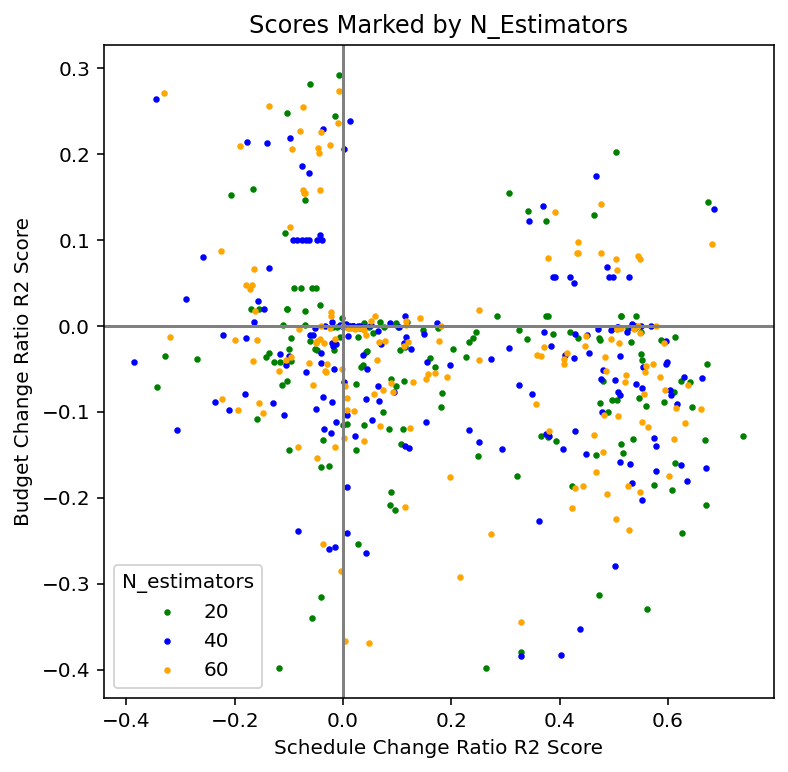

In [11]:
colors = ['g', 'b', 'orange', 'purple']
plt.figure(figsize=(6,6))

for i, e in enumerate(estimators):
    sct_data = results_no_outliers[results_no_outliers.n_estimators==e]
    plt.scatter(
        sct_data.test_score_sch,
        sct_data.test_score_bud,
        c=colors[i],
        s=5,
        label=e
    )

plt.legend()
plt.legend(title="N_estimators")
plt.title("Scores Marked by N_Estimators")
plt.axhline(c='gray')
plt.axvline(c='gray')
plt.xlabel('Schedule Change Ratio R2 Score')
plt.ylabel('Budget Change Ratio R2 Score');


**OBSERVATIONS:**

Here we want to see if there is any pattern in the n_estimators parameter.  We observe no trend that indicates any value performs consistently better than the others.

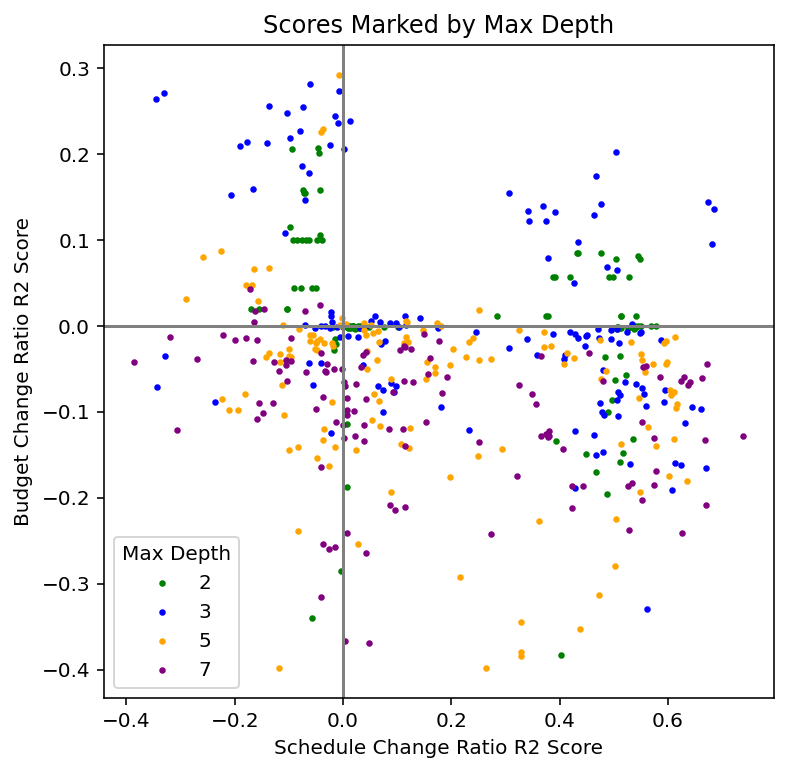

In [12]:
colors = ['g', 'b', 'orange', 'purple']
plt.figure(figsize=(6,6))

for i, m in enumerate(np.unique(max_depths)):
    sct_data = results_no_outliers[results_no_outliers.max_depth==m]
    plt.scatter(
        sct_data.test_score_sch,
        sct_data.test_score_bud,
        c=colors[i],
        s=5,
        label=m
    )

plt.legend(title="Max Depth")
plt.title("Scores Marked by Max Depth")
plt.axhline(c='gray')
plt.axvline(c='gray')
plt.xlabel('Schedule Change Ratio R2 Score')
plt.ylabel('Budget Change Ratio R2 Score');

**OBSERVATIONS:**

Here, we want to see if the maximum depth parameter has any consistent impact on the models.  We notice that the max depths of 3 perform consistently better with schedule change; however the best budget change model has a max depth of 5.   Since ADABoost learns 'fast' by also considering errors in training iterations, we can expext that lower numbers for max depth would product good results.  Predicting Budget values has been consistently more difficuly, so it makes sense that a larger max_depth is needed to find the optimal model for predicting the budget values.

# Best scoring model to predict "Budget Change Ratio"

[Return to top](#Notebook-contents)

Best Budget Change Ratio Prediction Model
Train Score: 0.994
Test Score: 0.2921


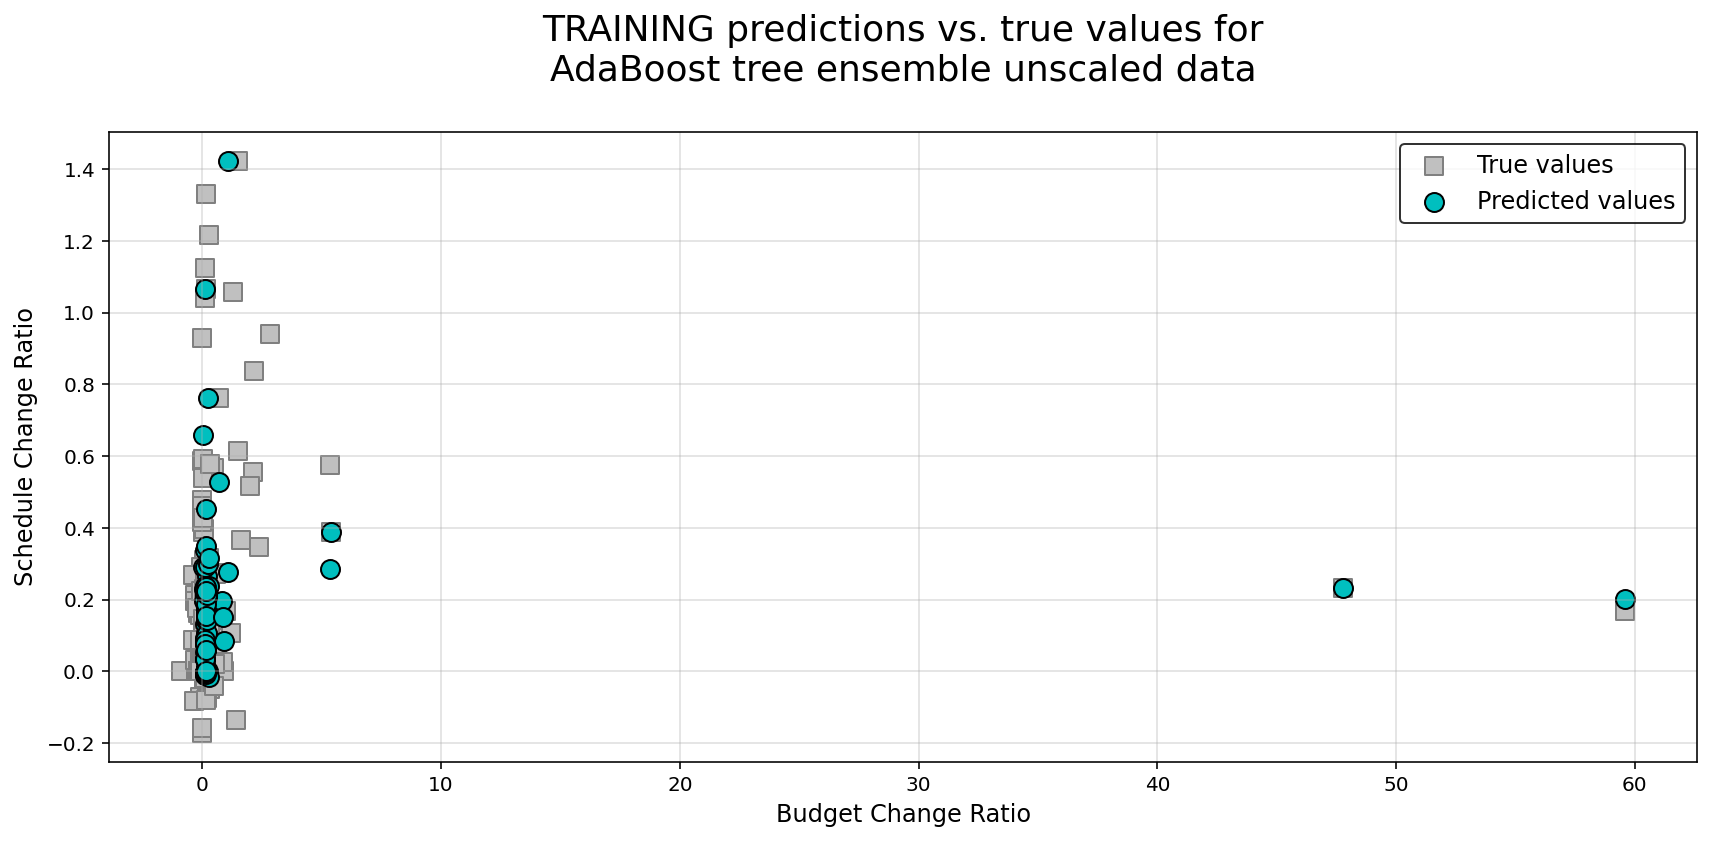

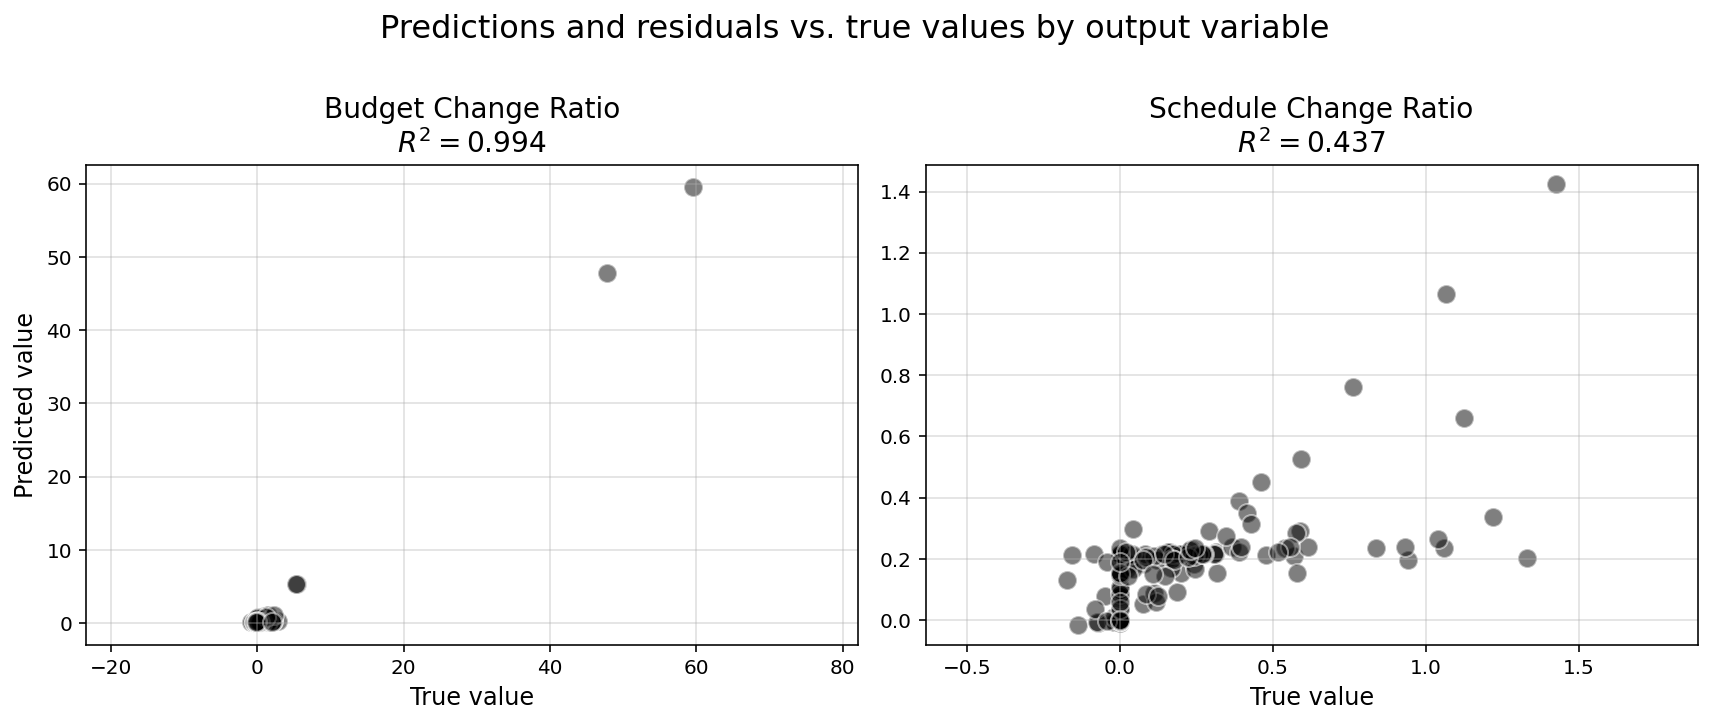

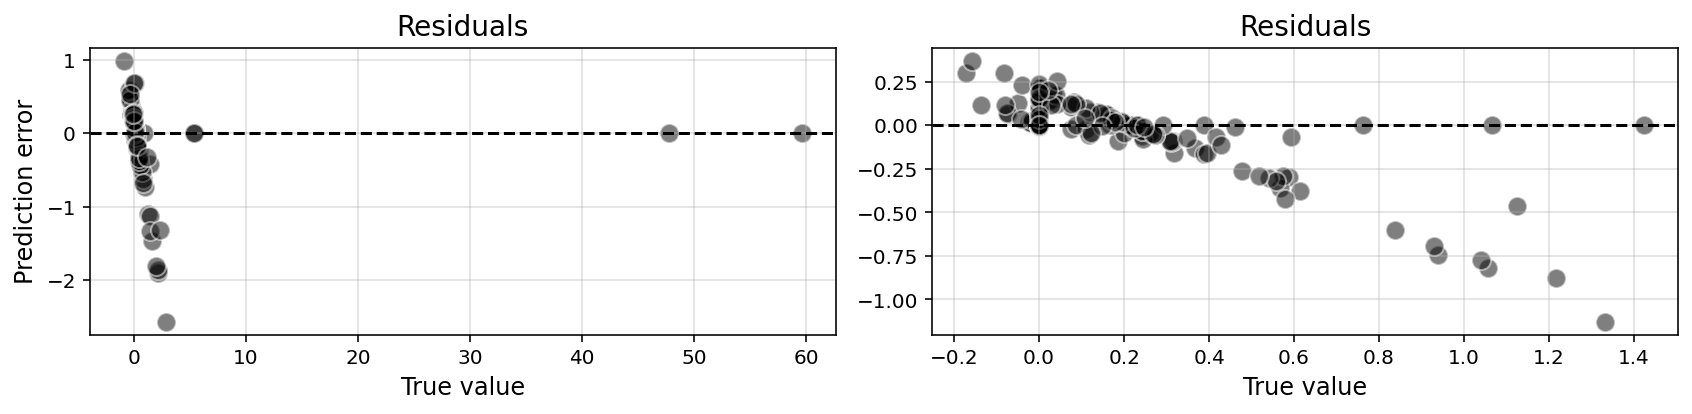

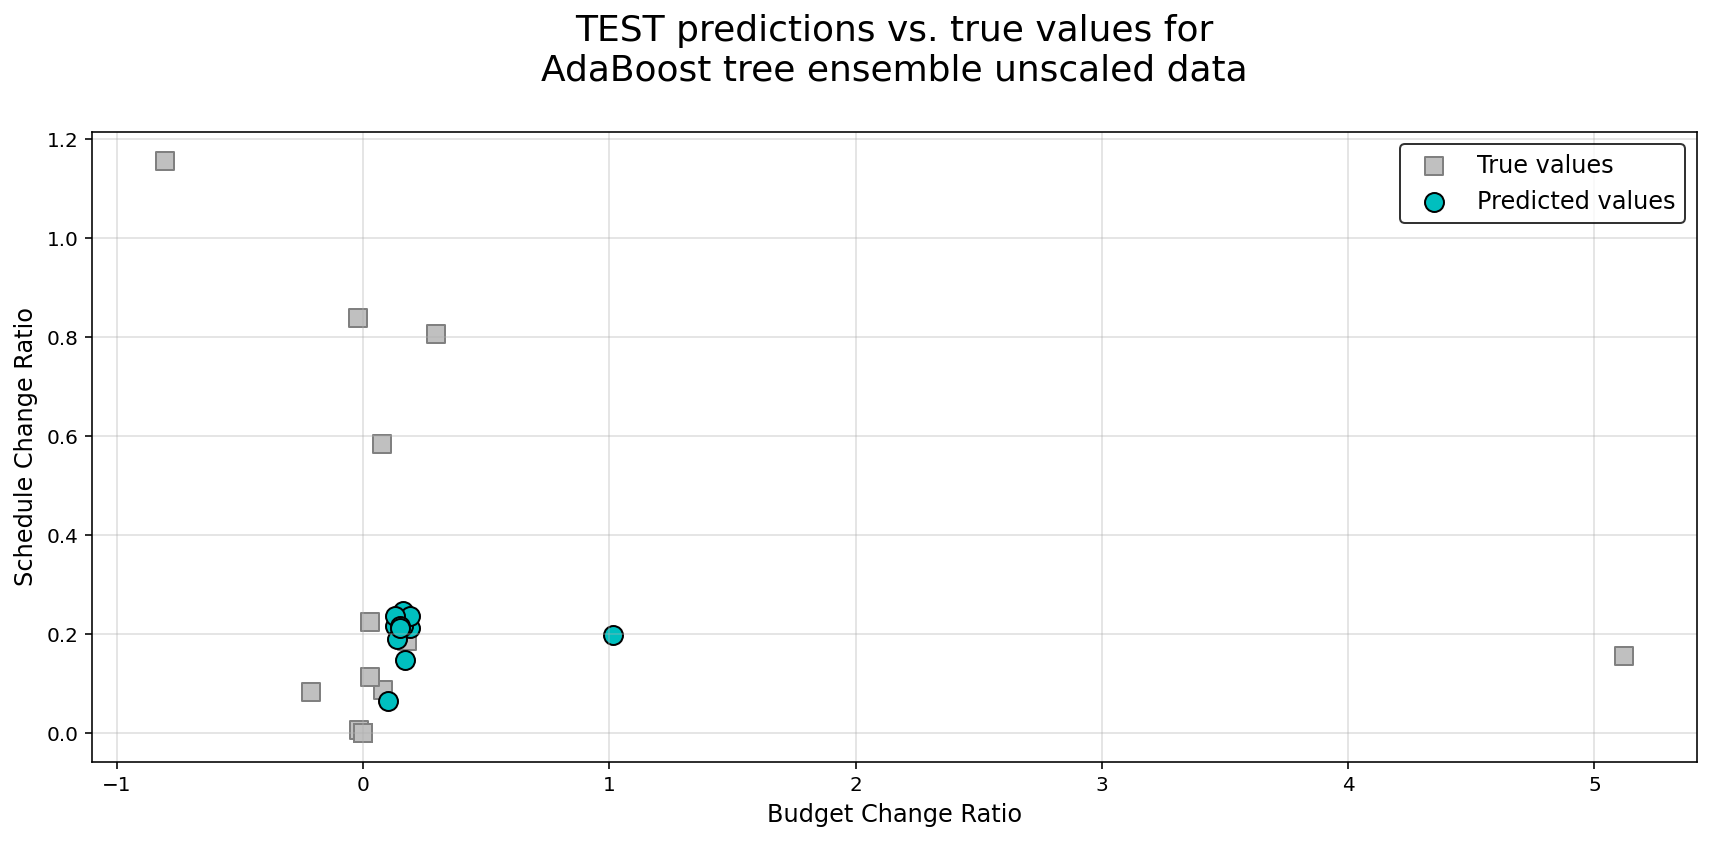

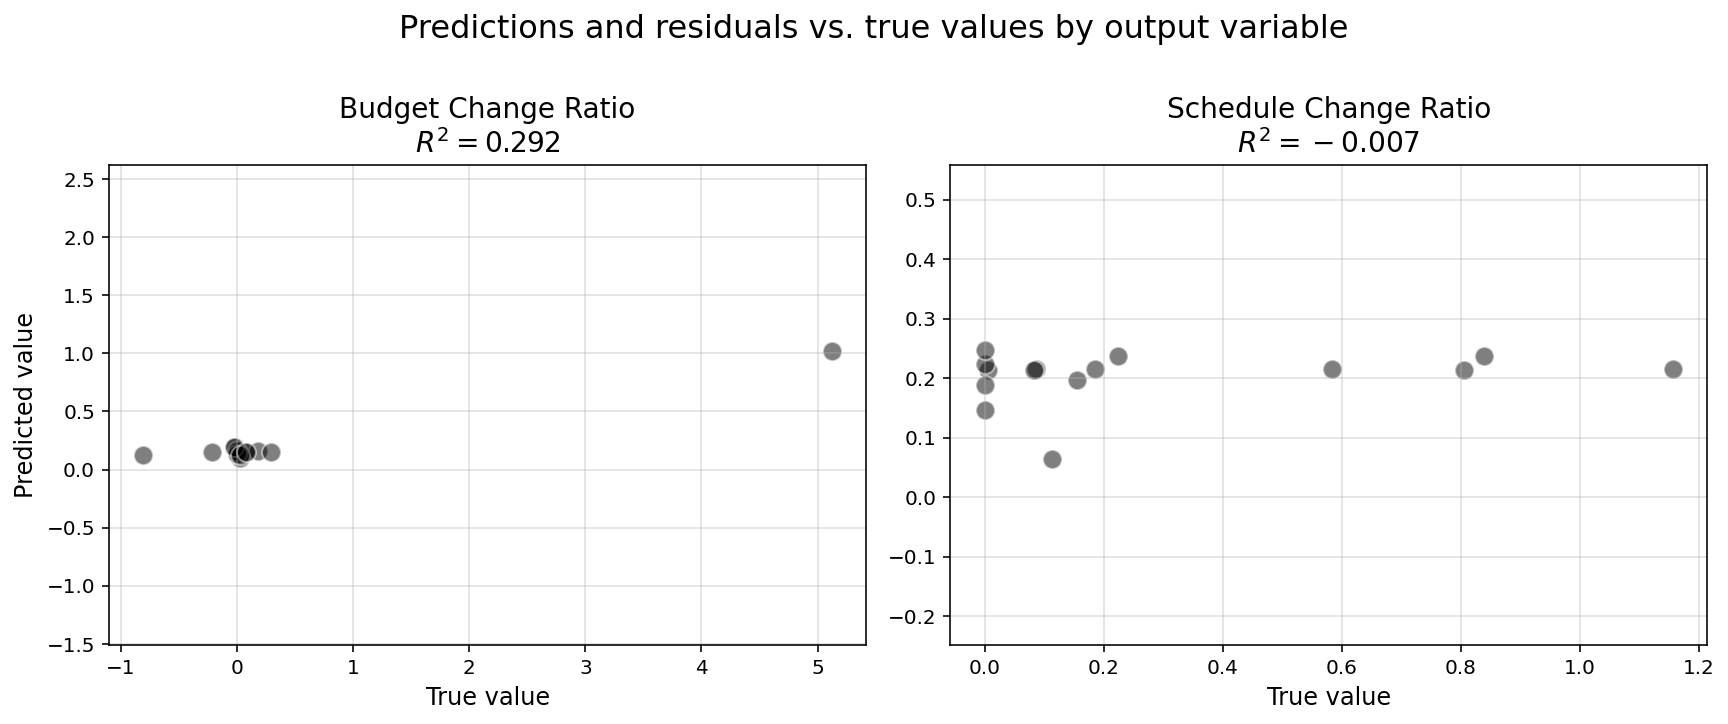

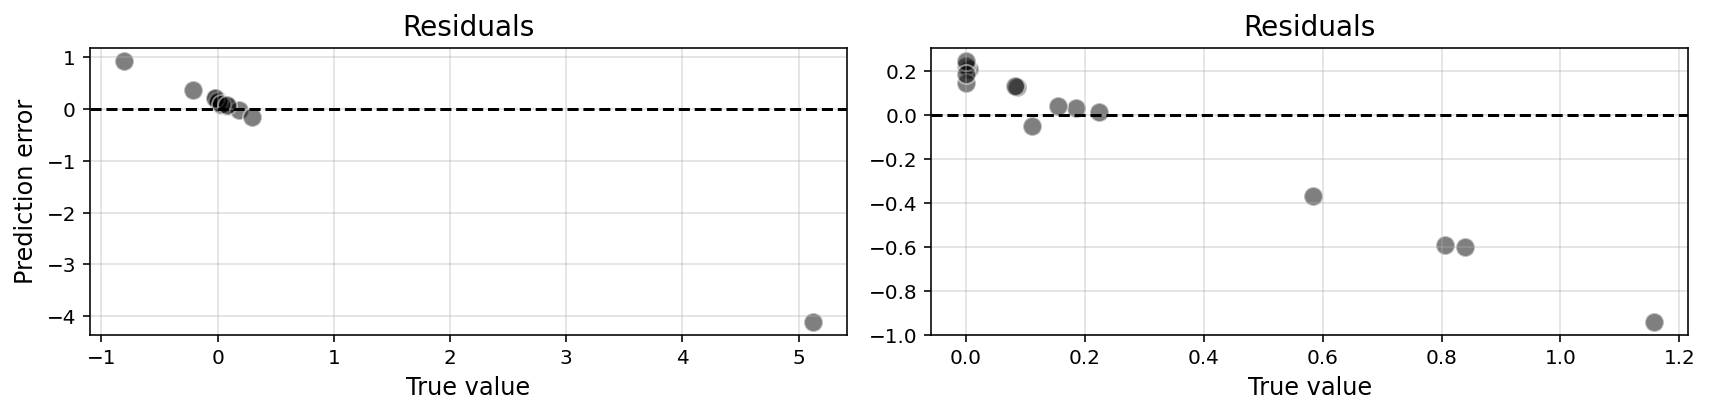

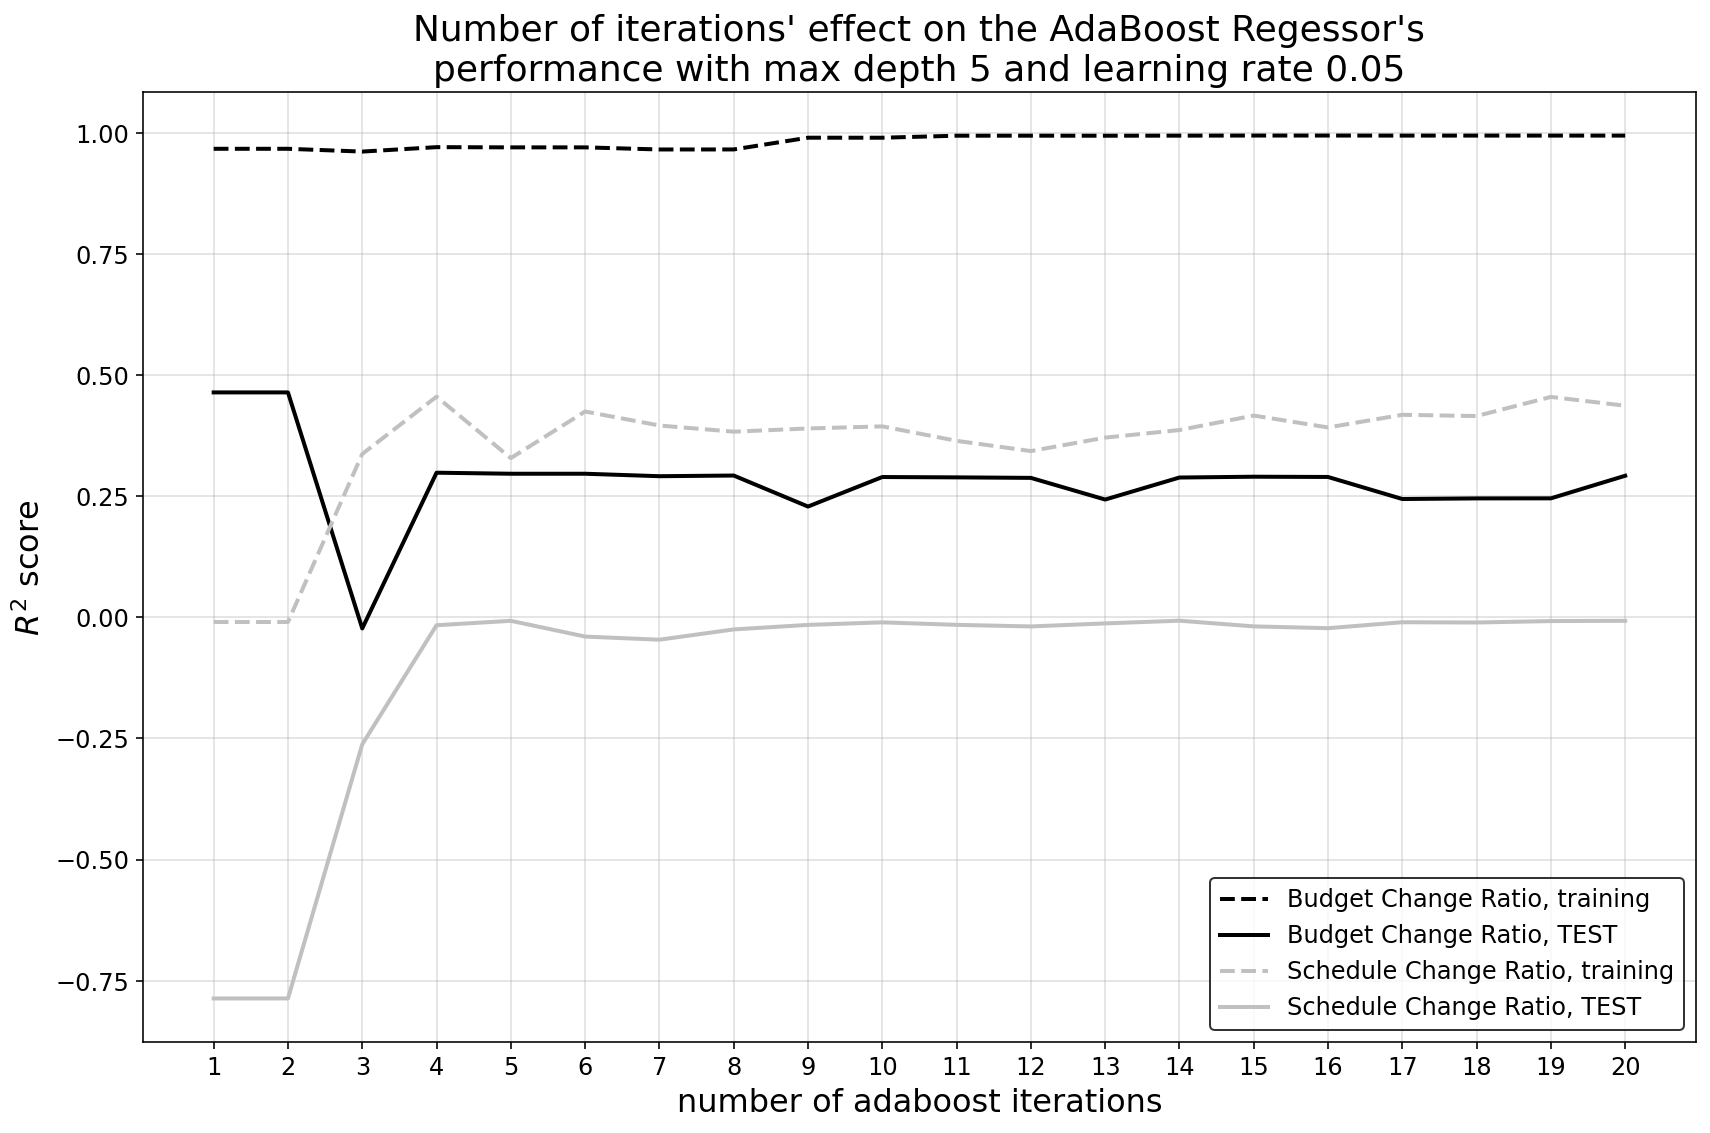

In [13]:
# best scoring model predicting schedule changes
idx = results.sort_values(by='test_score_bud', ascending=False).iloc[0].name
m = model_dicts[idx]
best_budget_model = m.copy()
print("Best Budget Change Ratio Prediction Model")
print(f"Train Score: {round(m['score']['train'][0],4)}")
print(f"Test Score: {round(m['score']['test'][0],4)}")
plot_true_pred(model_dict=m, dataset='train')
plot_true_pred(model_dict=m, dataset='test')
plot_adaboost_staged_scores(
    m,
    data_train[m.get('attributes')],
    data_test[m.get('attributes')],
    data_train[m.get('responses')],
    data_test[m.get('responses')]
)

# with open('../models/adaboost_regressor_budget_change_ratio.pickle', 'wb') as fp:
#     pickle.dump(
#         {
#             'desc': 'best adabost-regressor model predicting budget_change_ratio',
#             'model': m['model'],
#             'attributes': m['attributes'],
#             'responses': m['responses']
#         },
#         fp
#     )

**OBSERVATIONS:**

Here, the final graphic is most interesting.  This model is optimized for predicting the budget change.  The best result is found after the first iteration indicating that we may be using far too many iterations in the training.  On the first iteration, the model is already overtrained.  It is possible that the limited data set is not complex enough for this Adaboost model.  Schedule change performs poorly here which is reasonable.  We picked a model that was optimized for budget change.  Showing the performance of both responses emphasizes the choice we made not to try to find a model that predicts both budget and schedule.

# Best scoring model to predict "Schedule Change Ratio"

[Return to top](#Notebook-contents)

Best Schedule Change Ration Prediction Model
Train Score: 0.9576
Test Score: 0.7392


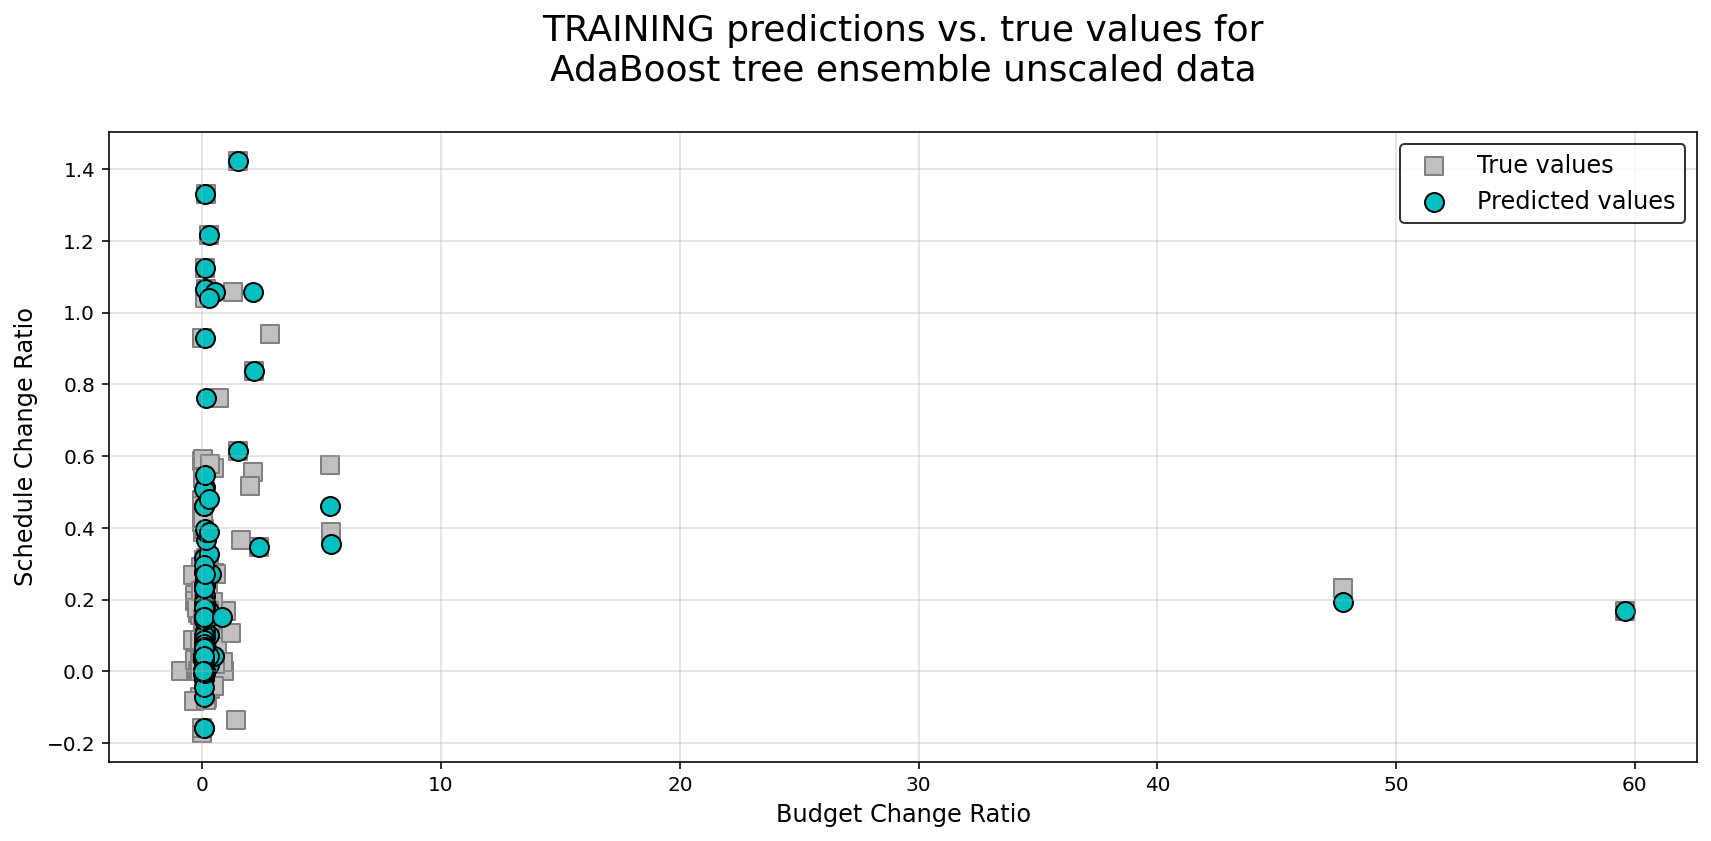

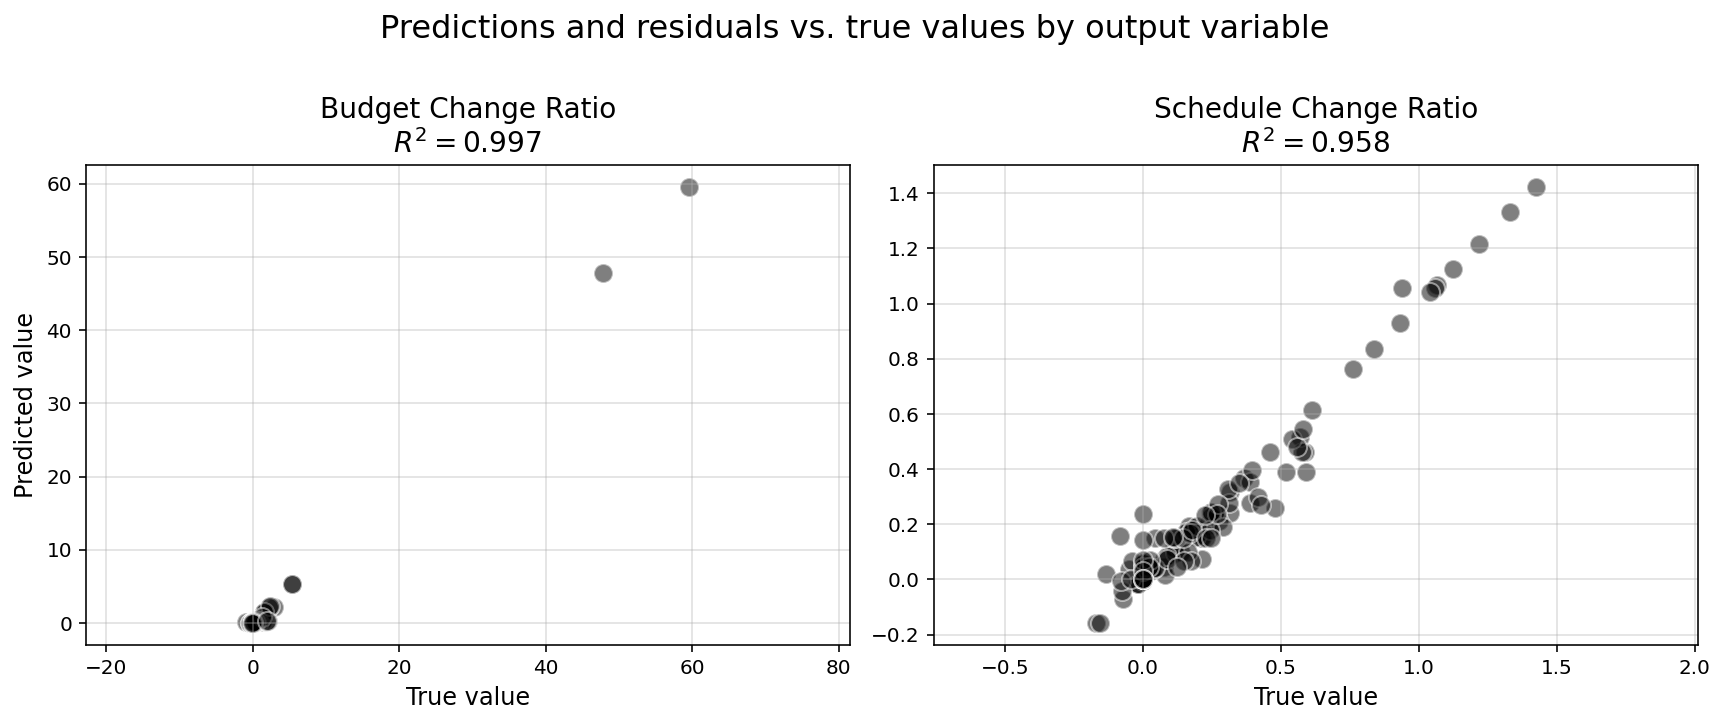

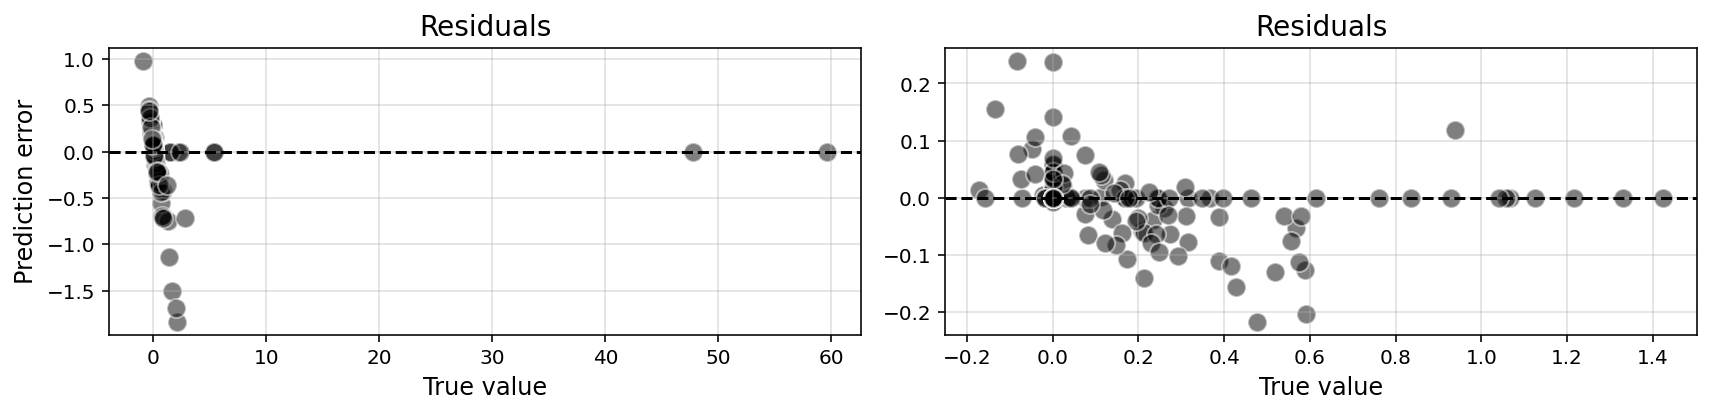

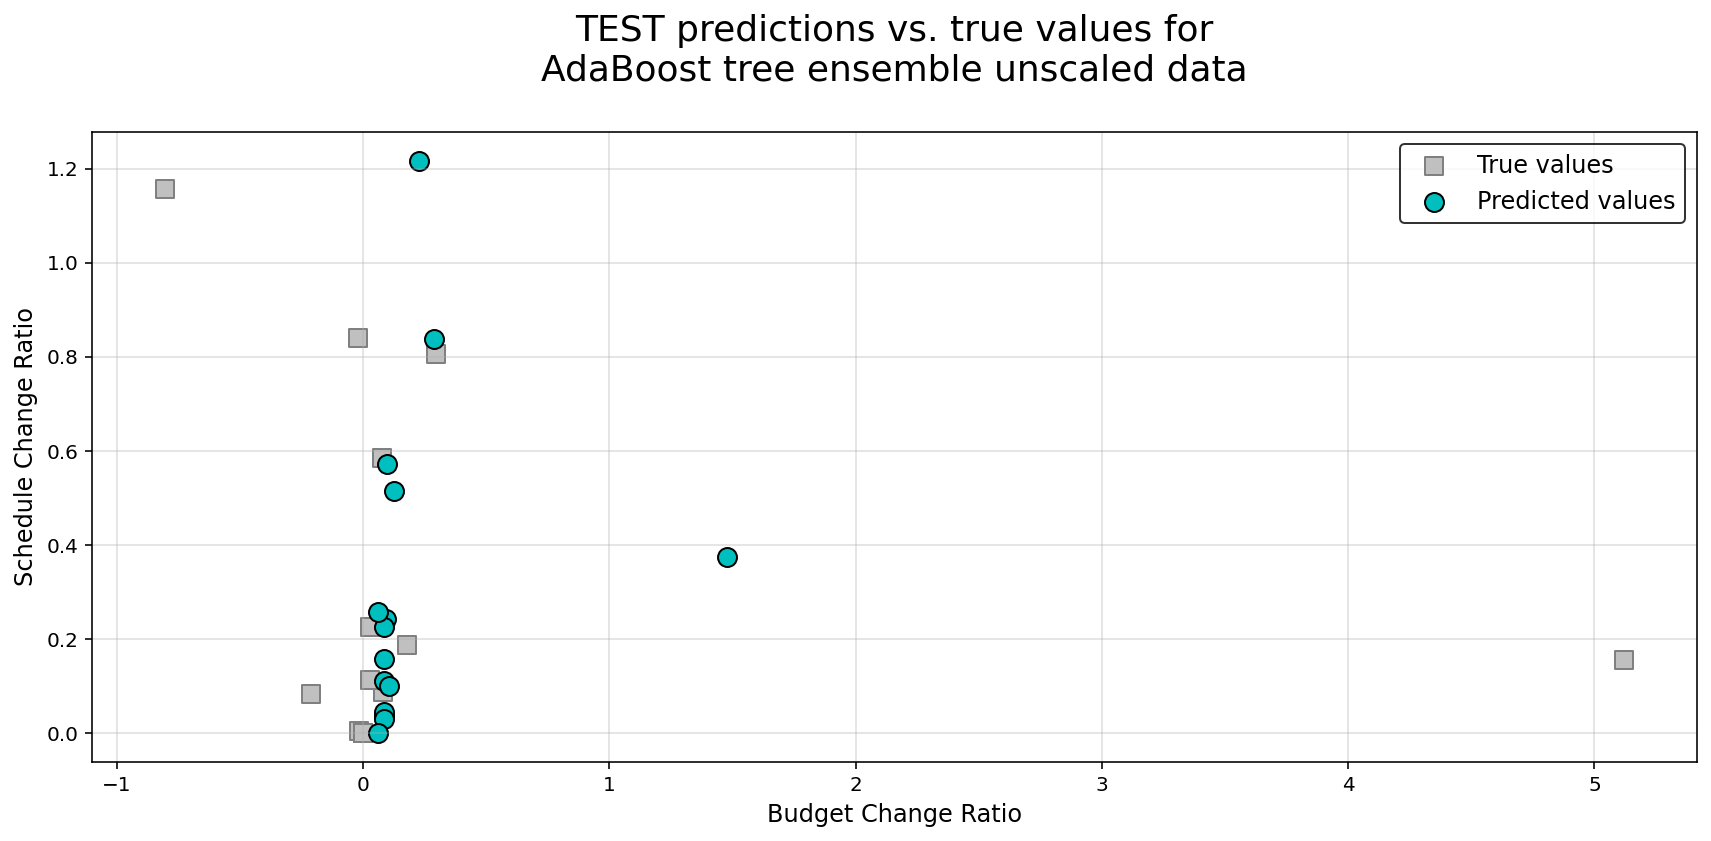

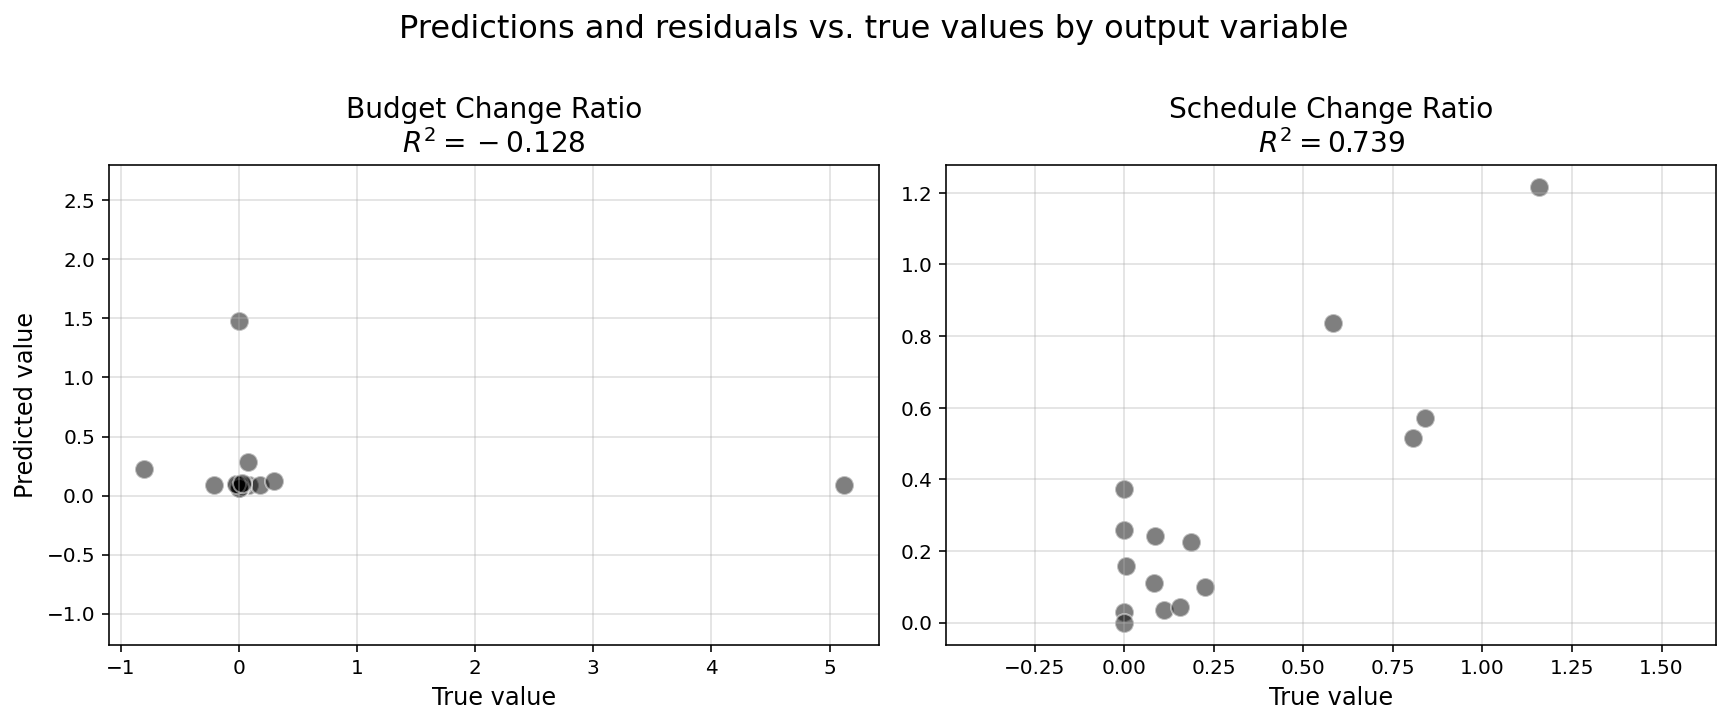

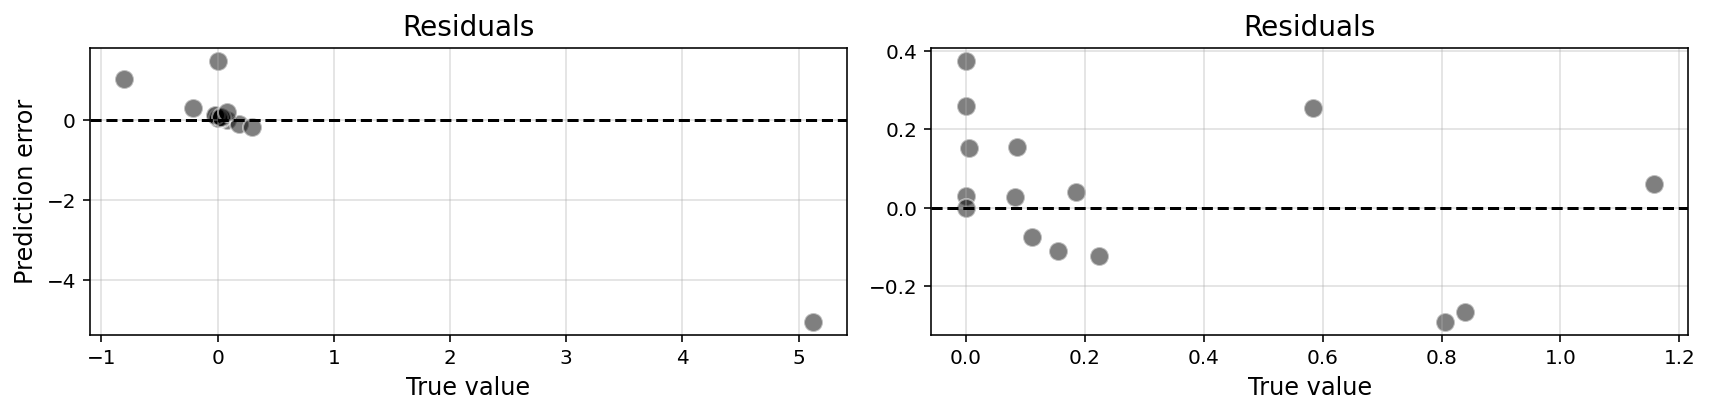

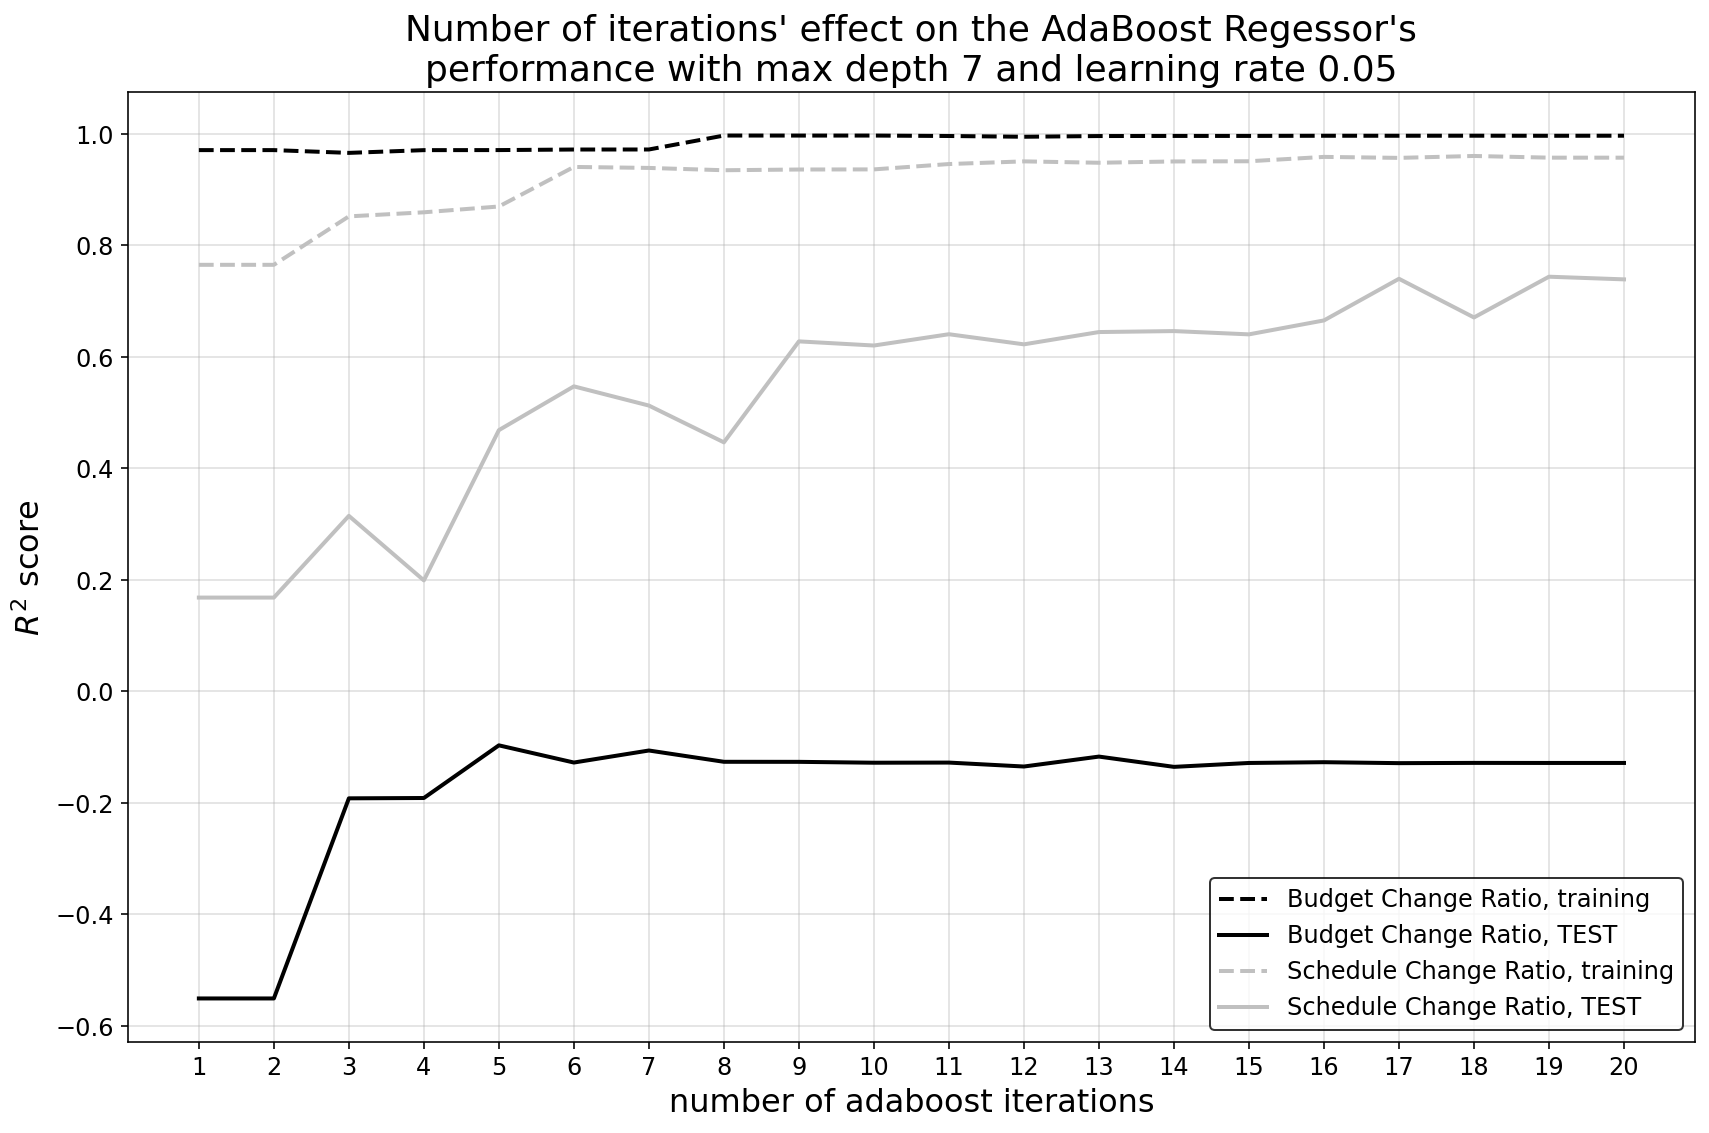

In [14]:
idx = results.sort_values(by='test_score_sch', ascending=False).iloc[0].name
m = model_dicts[idx]
best_schedule_model = m.copy()
print("Best Schedule Change Ration Prediction Model")
print(f"Train Score: {round(m['score']['train'][1],4)}")
print(f"Test Score: {round(m['score']['test'][1],4)}")
plot_true_pred(model_dict=m, dataset='train')
plot_true_pred(model_dict=m, dataset='test')
plot_adaboost_staged_scores(
    m,
    data_train[m.get('attributes')],
    data_test[m.get('attributes')],
    data_train[m.get('responses')],
    data_test[m.get('responses')]
)

# with open('../models/adaboost_regressor_schedule_change_ratio.pickle', 'wb') as fp:
#     pickle.dump(
#         {
#             'desc': 'best adabost-regressor model predicting schedule_change_ratio',
#             'model': m['model'],
#             'attributes': m['attributes'],
#             'responses': m['responses']
#         },
#         fp
#     )

**OBSERVATIONS:**

Again, the most compelling chart is the last one.  This model was optimized for schedule change and we see a reasonably good performance that increases with more iterations.  The model which trains on 60 iterations was not chosen as optimal so we can safely assume that performance drops after 40 iterations.  Again, we note that the budget predictions perform poorly here as this model is not optimized for budget predictions.